In [9]:
from collections import Counter
import glob
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

output_dir = "/app/dataset/preprocess/exp2"
os.makedirs(output_dir, exist_ok=True)

#### confirm tickers consistency of history and price

In [3]:
tickers_from_hist = []
for path in glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx"):
    df = pd.read_excel(path)
    tickers_from_hist.extend(df["Ticker"].tolist())

tickers_from_hist_counter = Counter(tickers_from_hist)
print(len(tickers_from_hist_counter))
print(sorted(tickers_from_hist_counter.items()))

72
[('AAVE', 53), ('ADA', 350), ('ALGO', 55), ('APE', 9), ('APT', 65), ('ARB', 2), ('ATOM', 236), ('AVAX', 217), ('AXS', 13), ('BAT', 41), ('BCH', 342), ('BNB', 350), ('CAKE', 3), ('COMP', 1), ('DASH', 106), ('DGB', 1), ('DOGE', 298), ('DOT', 264), ('EGLD', 3), ('ENA', 1), ('EOS', 138), ('ETC', 254), ('ETH', 350), ('FET', 16), ('FIL', 93), ('FTT', 69), ('HBAR', 54), ('ICP', 112), ('IMX', 13), ('INJ', 10), ('IOTA', 114), ('KLAY', 9), ('KSM', 3), ('LDO', 15), ('LINK', 329), ('LTC', 350), ('MANA', 15), ('MATIC', 172), ('MKR', 92), ('NEAR', 118), ('NEO', 120), ('OM', 10), ('OMG', 6), ('ONT', 83), ('QNT', 7), ('QTUM', 13), ('RENDER', 7), ('RUNE', 1), ('SHIB', 214), ('SNX', 7), ('SOL', 238), ('STX', 12), ('SUI', 52), ('TAO', 15), ('THETA', 40), ('TIA', 1), ('TON', 149), ('TRUMP', 2), ('TRX', 334), ('UMA', 4), ('UNI', 240), ('USTC', 25), ('VET', 117), ('WAVES', 15), ('WIF', 2), ('XEM', 114), ('XLM', 317), ('XMR', 276), ('XRP', 350), ('XTZ', 119), ('YFI', 6), ('ZEC', 87)]


In [4]:
tickers_from_price = []
for path in glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/price_data/*.xlsx"):
    assert path.endswith("USDT.xlsx")
    tickers_from_price.append(os.path.basename(path).replace("USDT.xlsx", ""))

print(len(tickers_from_price))

74


In [5]:
S_hist = set(tickers_from_hist_counter.keys())
S_price = set(tickers_from_price)
S_intersect = S_hist & S_price
print(len(S_intersect))

71


In [6]:
print(sorted(S_hist - S_intersect))
print(sorted(S_price - S_intersect))

['SHIB']
['1000SHIB', 'BTC', 'BTCDOM']


In [ ]:
#pd.DataFrame({"ticker": sorted(list(S_intersect))}).to_csv(f"{output_dir}/tickers.csv", index=False)

In [59]:
class TickerMapping:
    hist_to_price = {"SHIB": "1000SHIB"}
    price_to_hist = {"1000SHIB": "SHIB"}

    def hist_to_price(self, ticker: str) -> str:
        return self.hist_to_price.get(ticker, ticker)

    def price_to_hist(self, ticker: str) -> str:
        return self.price_to_hist.get(ticker, ticker)

#### confirm csv format of history and price

In [ ]:
for xlsx_path in glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx"):
    df = pd.read_excel(xlsx_path)
    assert df.columns.to_list() == ["Ticker", "Market Cap"], xlsx_path
    assert all(re.match("[0-9,\.]+[B,M]", x) for x in df["Market Cap"]), xlsx_path

In [50]:
for xlsx_path in glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/price_data/*.xlsx"):
    df = pd.read_excel(xlsx_path)
    assert df.columns.to_list() == ["open", "high", "low", "close", "volume", "date"], xlsx_path
    assert all(df[col].dtype == np.float64 for col in ["open", "high", "low", "close"]), xlsx_path
    assert df["volume"].dtype in (np.int64, np.float64), xlsx_path
    assert df["date"].dtype == '<M8[ns]', xlsx_path
    if not bool((df["date"].diff()[1:] == pd.Timedelta("1 days")).all()):
        print(xlsx_path, df["date"].diff()[1:].value_counts().sort_values())

/app/dataset/raw/20250928_现货价格数据和历史排名数据/price_data/FTTUSDT.xlsx date
311 days       1
1 days      1789
Name: count, dtype: int64


#### pairing time check

In [119]:
xlsx_path_list = sorted(glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx"))
min_hist = pd.to_datetime(re.findall(r"(\d{4}-\d{2}-\d{2})", os.path.basename(xlsx_path_list[0]))[0])
max_hist = pd.to_datetime(re.findall(r"(\d{4}-\d{2}-\d{2})", os.path.basename(xlsx_path_list[-1]))[0])
print(min_hist, max_hist, len(xlsx_path_list))

2019-01-03 00:00:00 2025-09-11 00:00:00 350


In [120]:
min_d_list = []
max_d_list = []
ticker_list = []
for xlsx_path in sorted(glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/price_data/*.xlsx")):
    df = pd.read_excel(xlsx_path)
    ticker = os.path.basename(xlsx_path).replace("USDT.xlsx", "")
    min_d_list.append(df["date"].min())
    max_d_list.append(df["date"].max())
    ticker_list.append(ticker)

2019-01-01 00:00:00 2025-09-19 00:00:00 2454


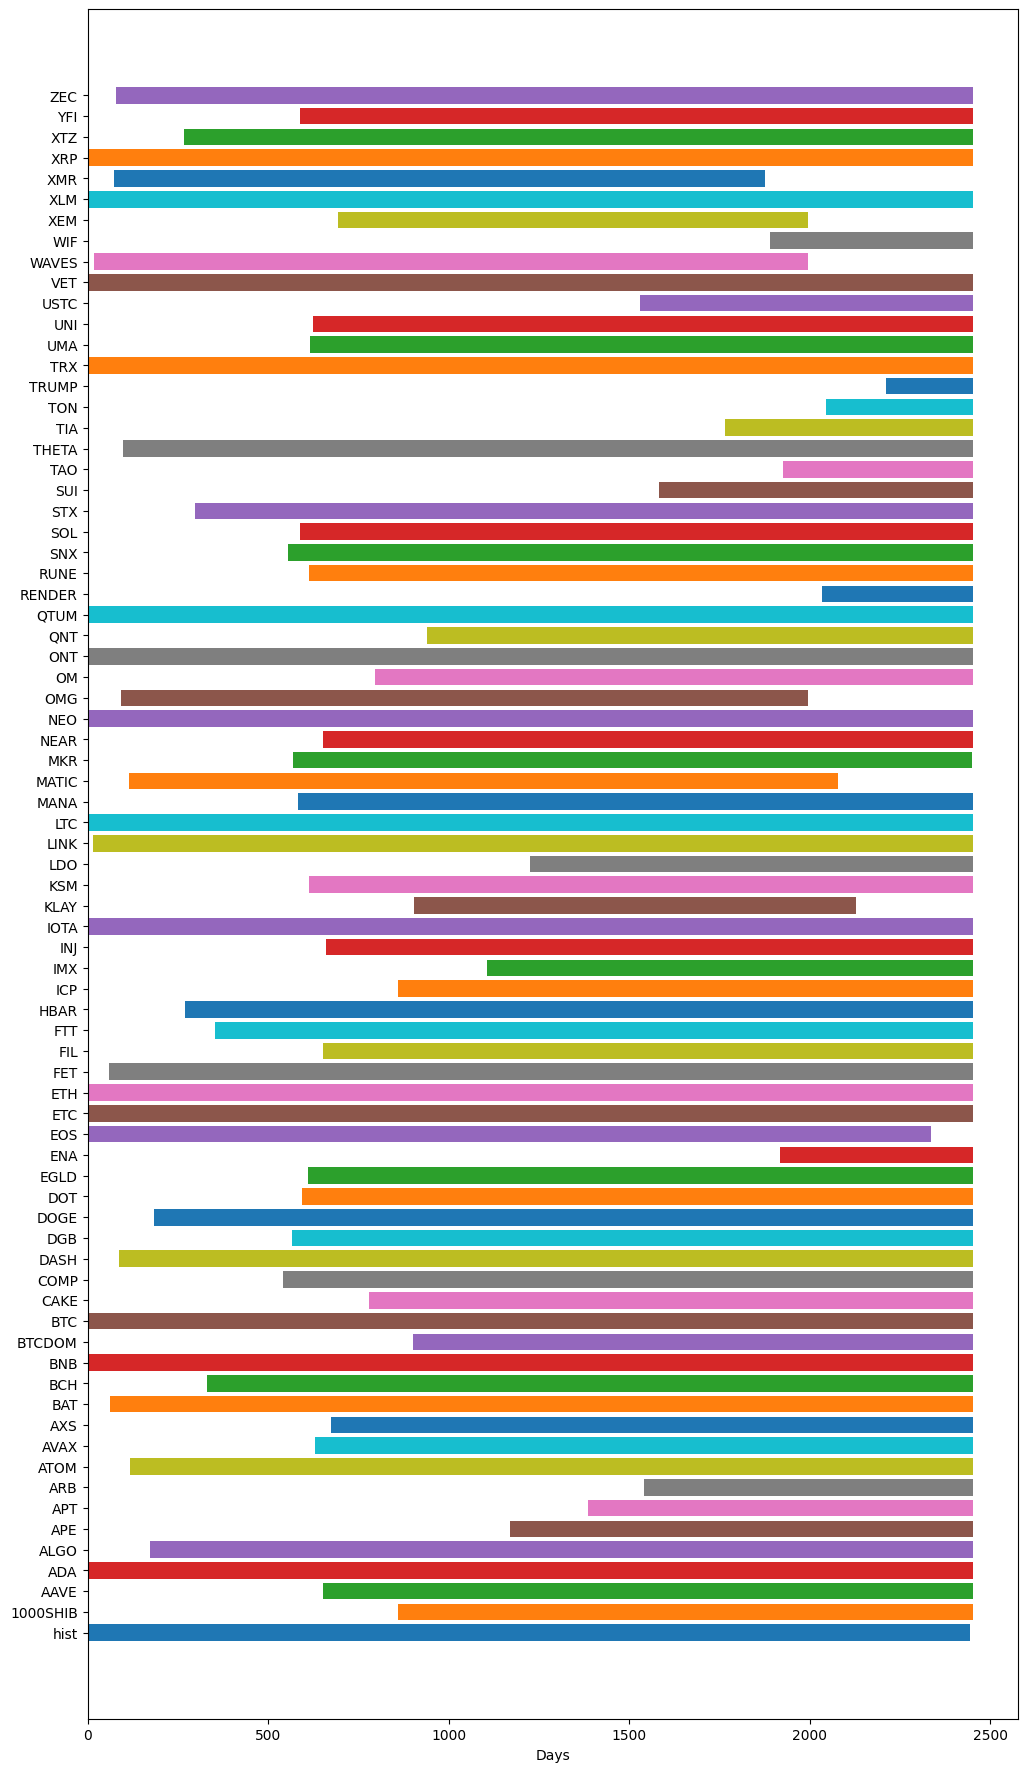

In [121]:
min_time = min(min(min_d_list), min_hist)
max_time = max(max(max_d_list), max_hist)
all_days = (max_time - min_time).days + 1
print(min_time, max_time, all_days)

plt.figure(figsize=(12, 0.3 * len(ticker_list)))
# history date
hist_start = (min_hist - min_time).days
hist_end = (max_hist - min_time).days
plt.barh(["hist"], [hist_end])
plt.barh(["hist"], [hist_start], color="white")
# price data
for mind, maxd, ticker in zip(min_d_list, max_d_list, ticker_list):
    start = (mind - min_time).days
    end = (maxd - min_time).days
    plt.barh([ticker], [end])
    plt.barh([ticker], [start], color="white")
plt.xlabel("Days")
plt.show()

#### Confirm history intervals

In [166]:
ser = []
for xlsx_path in sorted(glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx")):
    date = re.findall("\d{4}-\d{2}-\d{2}", os.path.basename(xlsx_path))[0]
    ser.append(date)
dates = pd.to_datetime(pd.Series(ser))
dates.diff().value_counts()

7 days    349
Name: count, dtype: int64

#### top N ratio

In [127]:
class Cap2Val:
    multipler = {"B": 1e9, "M": 1e6}
    
    @classmethod
    def cap2val(cls, s: str) -> int:
        num = s.split(".")[0]
        return int(float(num) * cls.multipler[s[-1]])

In [145]:
top_i_ratio_collect = []
for xlsx_path in glob.glob("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx"):
    df = pd.read_excel(xlsx_path)
    df["Market Cap"] = df["Market Cap"].apply(lambda x: Cap2Val.cap2val(x))
    df = df.sort_values("Market Cap", ascending=False)
    market_cap_sum = df["Market Cap"].sum()
    
    acc, top_i_ratio = 0, []
    for i in range(len(df)):
        acc += df["Market Cap"].iloc[i]
        top_i_ratio.append(float(acc / market_cap_sum))
    top_i_ratio_collect.append(top_i_ratio)

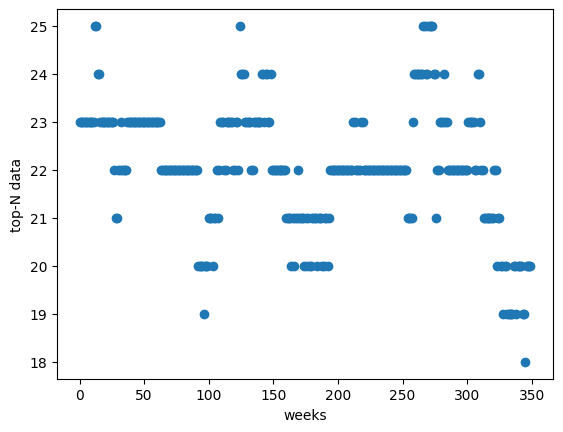

In [148]:
plt.scatter(range(len(top_i_ratio_collect)), [len(row) for row in top_i_ratio_collect])
plt.xlabel("weeks")
plt.ylabel("top-N data")
plt.show()

25


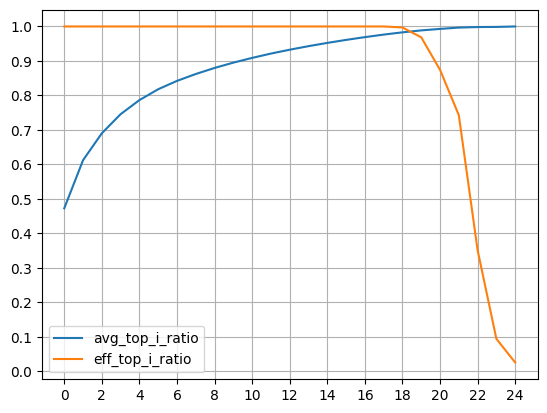

In [156]:
max_seq_len = max(len(seq) for seq in top_i_ratio_collect)
print(max_seq_len)

avg_top_i_ratio = []
eff_top_i_ratio = []
for week in range(max_seq_len):
    cnt, acc = 0, 0
    for i in range(len(top_i_ratio_collect)):
        if week < len(top_i_ratio_collect[i]):
            cnt += 1
            acc += top_i_ratio_collect[i][week]
    avg_top_i_ratio.append(acc / cnt if cnt > 0 else 0)
    eff_top_i_ratio.append(cnt / len(top_i_ratio_collect))

plt.plot(avg_top_i_ratio, label="avg_top_i_ratio")
plt.plot(eff_top_i_ratio, label="eff_top_i_ratio")
plt.grid()
plt.xticks(range(0, max_seq_len, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.show()